In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [3]:
def fold(n, X):
    i_max = n//2
    k = np.arange(1, n-1)
    multiplicity = 1 + (k == n - k).astype(float)[:i_max]
    if X.ndim == 1:
        folded = (X + X[::-1])[:i_max]
        divisor = multiplicity
    elif X.ndim == 2:
        folded = (X + X[:,::-1] + X[::-1,:] + X[::-1,::-1])[:i_max,:i_max]
        folded[np.diag_indices(i_max)] = 0
        divisor = np.outer(multiplicity, multiplicity)
    return folded / divisor

In [4]:
def stats(n, mode, **params):
    if mode == "kingman":
        xi, xi2 = c.fu_moments(n)
    elif mode in ["exponential", "two-epoch"]:
        xi = z.sigma_i(n, mode, **params)[1:-1]
        xi2 = z.sigma_ij(n, mode, **params)[1:-1,1:-1] + np.outer(xi, xi)
    elif mode == "beta":
        xi, xi2 = c.sfs_moments(n, params["alpha"])
    eta = fold(n, xi)
    eta2 = fold(n, xi2)
    pi = h.sfs2pi(eta, n)
    return eta / pi, eta2 / (pi**2)

In [5]:
def wpmi(eta, eta2):
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta))
    ret[np.diag_indices_from(ret)] = 0
    return ret

In [6]:
def lohi_cov(eta, eta2, cutoff=1):
    lo = np.sum(eta[:cutoff])
    hi = np.sum(eta[cutoff:])
    lohi = np.sum(eta2[:cutoff, cutoff:])
    return lohi / (lo*hi) - 1

In [7]:
def lohi_pmi(eta, eta2, cutoff=1):
    return np.log2(lohi_cov(eta, eta2, cutoff=cutoff) + 1)

In [8]:
def tajimasD(n, eta):
    theta_pi = h.sfs2pi(eta, n)
    theta_w  = np.sum(eta) / np.sum(1/np.arange(1,n))
    return theta_pi - theta_w

In [9]:
n = 39
mac = np.arange(1, n//2+1)

alphas = np.linspace(1.25, 1.75, 6)
gs = np.array([0.25, 0.5, 1.0, 2.0, 4.0, 8.0])

In [10]:
eta_kingman, eta2_kingman = stats(n, "kingman")

In [11]:
stats_exp = [stats(n, "exponential", g=g) for g in gs]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

In [12]:
stats_beta = [stats(n, "beta", alpha=a) for a in alphas]

In [13]:
wpmi_kingman = wpmi(eta_kingman, eta2_kingman)
wpmi_exp = [wpmi(eta, eta2) for eta, eta2 in stats_exp]
wpmi_beta = [wpmi(eta, eta2) for eta, eta2 in stats_beta]

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [83]:
def wpmi_pcolor(ax, mac, wpmi, scale, vm, **kwargs):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    np.fill_diagonal(wpmi, np.nan)
    return ax.pcolormesh(mac, mac, np.arcsinh(wpmi/scale), vmin=-vm, vmax=vm, **kwargs)

def wpmi_colorbar(ax, scale, vm, cmap):
    yticks = np.array([-9, -3, -1, 0, 1, 3, 9])
    yticks_transformed = 256 * (np.arcsinh(yticks) + vm)/(2*vm)
    ax.set_xticks([])
    ax.set_yticks(yticks_transformed)
    ax.set_yticklabels(yticks*scale)
    val = np.linspace(-vm, vm, 256)
    return ax.pcolormesh(val[:,None], cmap=cmap, vmin=-vm, vmax=vm)

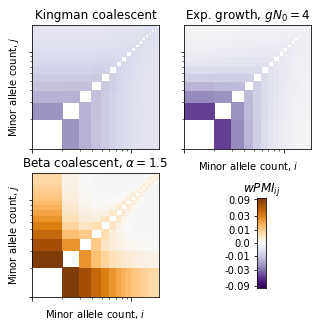

In [85]:
cmap = 'PuOr_r'
scale = 0.01
vm = 3

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(2,2,1)
wpmi_pcolor(ax, mac, wpmi_kingman, scale, vm, cmap=cmap)
ax.set_title('Kingman coalescent')
ax.set_ylabel('Minor allele count, $j$')

ax = fig.add_subplot(2,2,2)
wpmi_pcolor(ax, mac, wpmi_exp[-2], scale, vm, cmap=cmap)
ax.set_title('Exp. growth, $gN_0=4$')
ax.set_xlabel('Minor allele count, $i$')

ax = fig.add_subplot(2,2,3)
wpmi_pcolor(ax, mac, wpmi_beta[1], scale, vm, cmap=cmap)
ax.set_title(r'Beta coalescent, $\alpha=1.5$')
ax.set_xlabel('Minor allele count, $i$')
ax.set_ylabel('Minor allele count, $j$')

# ax = fig.add_axes([0.75, 0.15, 0.025, 0.3])
ax = fig.add_axes([0.75, 0.15, 0.025, 0.25])
wpmi_colorbar(ax, scale, vm, cmap)

# fig.savefig('../manuscript/figures/Figure1.pdf')

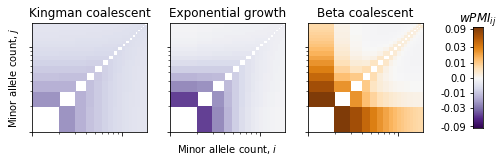

In [130]:
cmap = 'PuOr_r'
scale = 0.01
vm = 3

fig = plt.figure(figsize=(7, 2))

ax = fig.add_subplot(1,3,1)
wpmi_pcolor(ax, mac, wpmi_kingman, scale, vm, cmap=cmap)
ax.set_title('Kingman coalescent')
ax.set_ylabel('Minor allele count, $j$')

ax = fig.add_subplot(1,3,2)
wpmi_pcolor(ax, mac, wpmi_exp[-2], scale, vm, cmap=cmap)
ax.set_title("Exponential growth")
ax.set_xlabel('Minor allele count, $i$')

ax = fig.add_subplot(1,3,3)
wpmi_pcolor(ax, mac, wpmi_beta[1], scale, vm, cmap=cmap)
ax.set_title("Beta coalescent")

ax = fig.add_axes([1, 0.15, 0.02, 0.7])
wpmi_colorbar(ax, scale, vm, cmap)
ax.set_title('$wPMI_{ij}$')

fig.savefig('../manuscript/figures/Figure1.pdf')

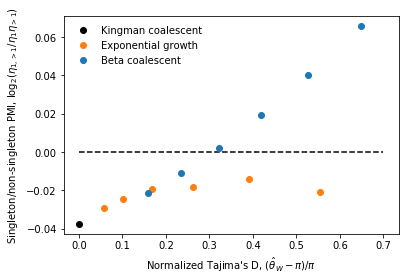

In [124]:
cutoff = 1
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(-tajimasD(n, eta_kingman), lohi_pmi(eta_kingman, eta2_kingman, cutoff=cutoff), 'o', c='k',
        label='Kingman coalescent')
for i, g in enumerate(gs):
    l = ax.plot(-tajimasD(n, stats_exp[i][0]), lohi_pmi(*stats_exp[i], cutoff=cutoff), 'o', c='C1')
    if i == 0:
        l[0].set_label('Exponential growth')
for i, a in enumerate(alphas):
    l = ax.plot(-tajimasD(n, stats_beta[i][0]), lohi_pmi(*stats_beta[i], cutoff=cutoff), 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.hlines(0, 0, 0.7, linestyle='dashed')
#plt.ylim([-0.031, 0.051])
ax.set_ylabel(r"Singleton/non-singleton PMI, $\log_2(\eta_{1,>1}/\eta_{1}\eta_{>1})$")
ax.set_xlabel(r"Normalized Tajima's D, $(\hat{\theta}_W - \pi) / \pi$")
ax.legend(frameon=False)

fig.savefig('../manuscript/figures/Figure2.pdf')

In [81]:
sd_kingman, sd2_kingman = stats(4, "kingman")
sd_exp = [stats(4, "exponential", g=g) for g in gs]
sd_beta = [stats(4, "beta", alpha=a) for a in alphas]

taus = np.logspace(-4, 1, 5, base=2)
fs = np.logspace(-4, -1, 5, base=2)
sd_2ep = [stats(4, "two-epoch", tau=tau, f=f) for f in fs for tau in taus]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

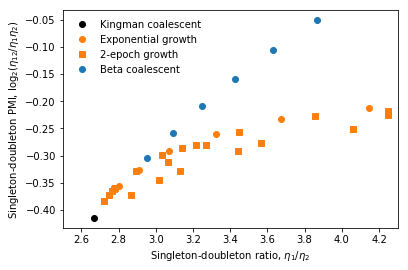

In [82]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(sd_kingman[0]/sd_kingman[1], np.log2(sd2_kingman[0,1] / (sd_kingman[1]*sd_kingman[0])), 'o', c='k', label='Kingman coalescent')

for i, (sd, sd2) in enumerate(sd_exp):
    l = ax.plot(sd[0]/sd[1], np.log2(sd2[0,1] / (sd[1]*sd[0])), 'o', c='C1')
    if i == 0:
        l[0].set_label("Exponential growth")
for i, (sd, sd2) in enumerate(sd_2ep):
    l = ax.plot(sd[0]/sd[1], np.log2(sd2[0,1] / (sd[1]*sd[0])), 's', c='C1')
    if i == 0:
        l[0].set_label("2-epoch growth")

for i, (sd, sd2) in enumerate(sd_beta):
    l = ax.plot(sd[0]/sd[1], np.log2(sd2[0,1] / (sd[1]*sd[0])), 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.set_xlim([2.5,4.3])
ax.set_xlabel('Singleton-doubleton ratio, $\eta_1 / \eta_2$')
ax.set_ylabel('Singleton-doubleton PMI, $\log_2(\eta_{12} / \eta_1 \eta_2)$')

ax.legend(frameon=False)

fig.savefig('../manuscript/figures/Figure3.pdf')